In [1]:
import moxing as mox
mox.file.copy_parallel(src_url="obs://ascend-professional-construction-dataset/deep-learning/deeplabv3-mindspore/VOC2012", dst_url="./VOC2012")

INFO:root:Using MoXing-v2.0.0.rc2.4b57a67b-4b57a67b
INFO:root:Using OBS-Python-SDK-3.20.9.1
INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:Listing OBS: 4000
INFO:root:Listing OBS: 5000
INFO:root:Listing OBS: 6000
INFO:root:Listing OBS: 7000
INFO:root:Listing OBS: 8000
INFO:root:Listing OBS: 9000
INFO:root:Listing OBS: 10000
INFO:root:Listing OBS: 11000
INFO:root:Listing OBS: 12000
INFO:root:Listing OBS: 13000
INFO:root:Listing OBS: 14000
INFO:root:Listing OBS: 15000
INFO:root:Listing OBS: 16000
INFO:root:Listing OBS: 17000
INFO:root:Listing OBS: 18000
INFO:root:Listing OBS: 19000
INFO:root:Listing OBS: 20000
INFO:root:Listing OBS: 21000
INFO:root:Listing OBS: 22000
INFO:root:Listing OBS: 23000
INFO:root:Listing OBS: 24000
INFO:root:Listing OBS: 25000
INFO:root:Listing OBS: 26000
INFO:root:Listing OBS: 27000
INFO:root:Listing OBS: 28000
INFO:root:Listing OBS: 29000
INFO:root:Listing OBS: 30000
INFO:root:Listing OBS: 31000
INFO:root:Listing 

In [2]:
import moxing as mox
mox.file.copy_parallel(src_url="obs://ascend-professional-construction-dataset/deep-learning/deeplabv3-mindspore/ckpt", dst_url="./ckpt")

In [3]:
import os
import numpy as np
import scipy.io
import pickle
from PIL import Image
import shutil

import cv2

from mindspore.mindrecord import FileWriter
import mindspore.dataset as de

cv2.setNumThreads(0)


class SegDataset:
    def __init__(self,
                 image_mean,
                 image_std,
                 data_file='',
                 batch_size=32,
                 crop_size=512,
                 max_scale=2.0,
                 min_scale=0.5,
                 ignore_label=255,
                 num_classes=21,
                 num_readers=2,
                 num_parallel_calls=4,
                 shard_id=None,
                 shard_num=None):

        self.data_file = data_file
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.image_mean = np.array(image_mean, dtype=np.float32)
        self.image_std = np.array(image_std, dtype=np.float32)
        self.max_scale = max_scale
        self.min_scale = min_scale
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.num_readers = num_readers
        self.num_parallel_calls = num_parallel_calls
        self.shard_id = shard_id
        self.shard_num = shard_num
        self.voc_img_dir = os.path.join(self.data_file,'JPEGImages')
        self.voc_anno_dir = os.path.join(self.data_file,'SegmentationClass')
        self.voc_train_lst = os.path.join(self.data_file,'ImageSets/Segmentation/train.txt')
        self.voc_val_lst = os.path.join(self.data_file,'ImageSets/Segmentation/val.txt')
        
        self.voc_anno_gray_dir = os.path.join(self.data_file,'SegmentationClassGray')
        self.mindrecord_save =  os.path.join(self.data_file,'VOC_mindrecord')
                                       
        assert max_scale > min_scale

    def preprocess_(self, image, label):
        # bgr image
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        image_out = (image_out - self.image_mean) / self.image_std
        h_, w_ = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = h_ - new_h, w_ - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, h_ - self.crop_size + 1)
        offset_w = np.random.randint(0, w_ - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]

        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]

        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        return image_out, label_out

    
    def get_gray_dataset(self):
        if os.path.exists(self.voc_anno_gray_dir):
            print('the gray file is already exists！')
            return
        os.makedirs(self.voc_anno_gray_dir)

        # convert voc color png to gray png
        print('converting voc color png to gray png ...')
        for ann in os.listdir(self.voc_anno_dir):
            ann_im = Image.open(os.path.join(self.voc_anno_dir, ann))
            ann_im = Image.fromarray(np.array(ann_im))
            ann_im.save(os.path.join(self.voc_anno_gray_dir, ann))
        print('converting done')
        
    def get_mindrecord_dataset(self, is_training,num_shards=1, shuffle=True):
        datas = []
        if is_training:
            data_lst = self.voc_train_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'train')
        else:
            data_lst = self.voc_val_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'eval')
        
        if os.path.exists(self.mindrecord_save):
            #shutil.rmtree(self.mindrecord_save)
            print('mindrecord file is already exists！')
            self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
            return
        
        with open(data_lst) as f:
            lines = f.readlines()
        if shuffle:
            np.random.shuffle(lines)
            
        print('creating mindrecord dataset...')
        os.makedirs(self.mindrecord_save)
        self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
        print('number of samples:', len(lines))
        seg_schema = {"file_name": {"type": "string"}, "label": {"type": "bytes"}, "data": {"type": "bytes"}}
        writer = FileWriter(file_name=self.mindrecord_save, shard_num=num_shards)
        writer.add_schema(seg_schema, "seg_schema")
        cnt = 0
        for l in lines:
            id_ = l.strip()
            img_path = os.path.join(self.voc_img_dir, id_ + '.jpg')
            label_path = os.path.join(self.voc_anno_gray_dir, id_ + '.png')
            
            sample_ = {"file_name": img_path.split('/')[-1]}
            with open(img_path, 'rb') as f:
                sample_['data'] = f.read()
            with open(label_path, 'rb') as f:
                sample_['label'] = f.read()
            datas.append(sample_)
            cnt += 1
            if cnt % 1000 == 0:
                writer.write_raw_data(datas)
                print('number of samples written:', cnt)
                datas = []

        if datas:
            writer.write_raw_data(datas)
        writer.commit()
        print('number of samples written:', cnt)
        print('Create Mindrecord Done')
        
    def get_dataset(self, repeat=1):
        data_set = de.MindDataset(dataset_file=self.mindrecord_save, columns_list=["data", "label"],
                                  shuffle=True, num_parallel_workers=self.num_readers,
                                  num_shards=self.shard_num, shard_id=self.shard_id)
        transforms_list = self.preprocess_
        data_set = data_set.map(operations=transforms_list, input_columns=["data", "label"],
                                output_columns=["data", "label"],
                                num_parallel_workers=self.num_parallel_calls)
        data_set = data_set.shuffle(buffer_size=self.batch_size * 10)
        data_set = data_set.batch(self.batch_size, drop_remainder=True)
        data_set = data_set.repeat(repeat)
        return data_set

[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:14:37.690.181 [mindspore/_check_version.py:207] MindSpore version 1.1.1 and "te" wheel package version 1.0 does not match, reference to the match info on: https://www.mindspore.cn/install
MindSpore version 1.1.1 and "topi" wheel package version 0.6.0 does not match, reference to the match info on: https://www.mindspore.cn/install
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:14:38.402.516 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


In [4]:
import mindspore.nn as nn
from mindspore.ops import operations as P


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, weight_init='xavier_uniform')


def conv3x3(in_planes, out_planes, stride=1, dilation=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, pad_mode='pad', padding=padding,
                     dilation=dilation, weight_init='xavier_uniform')


class Resnet(nn.Cell):
    def __init__(self, block, block_num, output_stride, use_batch_statistics=True):
        super(Resnet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, pad_mode='pad', padding=3,
                               weight_init='xavier_uniform')
        self.bn1 = nn.BatchNorm2d(self.inplanes, use_batch_statistics=use_batch_statistics)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        self.layer1 = self._make_layer(block, 64, block_num[0], use_batch_statistics=use_batch_statistics)
        self.layer2 = self._make_layer(block, 128, block_num[1], stride=2, use_batch_statistics=use_batch_statistics)

        if output_stride == 16:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=2, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)
        elif output_stride == 8:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=1, base_dilation=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=4, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)

    def _make_layer(self, block, planes, blocks, stride=1, base_dilation=1, grids=None, use_batch_statistics=True):
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.SequentialCell([
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, use_batch_statistics=use_batch_statistics)
            ])

        if grids is None:
            grids = [1] * blocks

        layers = [
            block(self.inplanes, planes, stride, downsample, dilation=base_dilation * grids[0],
                  use_batch_statistics=use_batch_statistics)
        ]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(self.inplanes, planes, dilation=base_dilation * grids[i],
                      use_batch_statistics=use_batch_statistics))

        return nn.SequentialCell(layers)

    def construct(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out


class Bottleneck(nn.Cell):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, use_batch_statistics=True):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)

        self.conv2 = conv3x3(planes, planes, stride, dilation, dilation)
        self.bn2 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)

        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, use_batch_statistics=use_batch_statistics)

        self.relu = nn.ReLU()
        self.downsample = downsample

        self.add = P.TensorAdd()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.add(out, identity)
        out = self.relu(out)
        return out


class ASPP(nn.Cell):
    def __init__(self, atrous_rates, phase='train', in_channels=2048, num_classes=21,
                 use_batch_statistics=True):
        super(ASPP, self).__init__()
        self.phase = phase
        out_channels = 256
        self.aspp1 = ASPPConv(in_channels, out_channels, atrous_rates[0], use_batch_statistics=use_batch_statistics)
        self.aspp2 = ASPPConv(in_channels, out_channels, atrous_rates[1], use_batch_statistics=use_batch_statistics)
        self.aspp3 = ASPPConv(in_channels, out_channels, atrous_rates[2], use_batch_statistics=use_batch_statistics)
        self.aspp4 = ASPPConv(in_channels, out_channels, atrous_rates[3], use_batch_statistics=use_batch_statistics)
        self.aspp_pooling = ASPPPooling(in_channels, out_channels)
        self.conv1 = nn.Conv2d(out_channels * (len(atrous_rates) + 1), out_channels, kernel_size=1,
                               weight_init='xavier_uniform')
        self.bn1 = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, num_classes, kernel_size=1, weight_init='xavier_uniform', has_bias=True)
        self.concat = P.Concat(axis=1)
        self.drop = nn.Dropout(0.3)

    def construct(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.aspp_pooling(x)

        x = self.concat((x1, x2))
        x = self.concat((x, x3))
        x = self.concat((x, x4))
        x = self.concat((x, x5))

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.phase == 'train':
            x = self.drop(x)
        x = self.conv2(x)
        return x


class ASPPPooling(nn.Cell):
    def __init__(self, in_channels, out_channels, use_batch_statistics=True):
        super(ASPPPooling, self).__init__()
        self.conv = nn.SequentialCell([
            nn.Conv2d(in_channels, out_channels, kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics),
            nn.ReLU()
        ])
        self.shape = P.Shape()

    def construct(self, x):
        size = self.shape(x)
        out = nn.AvgPool2d(size[2])(x)
        out = self.conv(out)
        out = P.ResizeNearestNeighbor((size[2], size[3]), True)(out)
        return out


class ASPPConv(nn.Cell):
    def __init__(self, in_channels, out_channels, atrous_rate=1, use_batch_statistics=True):
        super(ASPPConv, self).__init__()
        if atrous_rate == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=False, weight_init='xavier_uniform')
        else:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, pad_mode='pad', padding=atrous_rate,
                             dilation=atrous_rate, weight_init='xavier_uniform')
        bn = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        relu = nn.ReLU()
        self.aspp_conv = nn.SequentialCell([conv, bn, relu])

    def construct(self, x):
        out = self.aspp_conv(x)
        return out


class DeepLabV3(nn.Cell):
    def __init__(self, phase='train', num_classes=21, output_stride=16, freeze_bn=False):
        super(DeepLabV3, self).__init__()
        use_batch_statistics = not freeze_bn
        self.resnet = Resnet(Bottleneck, [3, 4, 23, 3], output_stride=output_stride,
                             use_batch_statistics=use_batch_statistics)
        self.aspp = ASPP([1, 6, 12, 18], phase, 2048, num_classes,
                         use_batch_statistics=use_batch_statistics)
        self.shape = P.Shape()

    def construct(self, x):
        size = self.shape(x)
        out = self.resnet(x)
        out = self.aspp(out)
        out = P.ResizeBilinear((size[2], size[3]), True)(out)
        return out

In [5]:
def cosine_lr(base_lr, decay_steps, total_steps):
    for i in range(total_steps):
        step_ = min(i, decay_steps)
        yield base_lr * 0.5 * (1 + np.cos(np.pi * step_ / decay_steps))


def poly_lr(base_lr, decay_steps, total_steps, end_lr=0.0001, power=0.9):
    for i in range(total_steps):
        step_ = min(i, decay_steps)
        yield (base_lr - end_lr) * ((1.0 - step_ / decay_steps) ** power) + end_lr


def exponential_lr(base_lr, decay_steps, decay_rate, total_steps, staircase=False):
    for i in range(total_steps):
        if staircase:
            power_ = i // decay_steps
        else:
            power_ = float(i) / decay_steps
        yield base_lr * (decay_rate ** power_)

In [6]:
from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore.ops import operations as P


class SoftmaxCrossEntropyLoss(nn.Cell):
    def __init__(self, num_cls=21, ignore_label=255):
        super(SoftmaxCrossEntropyLoss, self).__init__()
        self.one_hot = P.OneHot(axis=-1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.cast = P.Cast()
        self.ce = nn.SoftmaxCrossEntropyWithLogits()
        self.not_equal = P.NotEqual()
        self.num_cls = num_cls
        self.ignore_label = ignore_label
        self.mul = P.Mul()
        self.sum = P.ReduceSum(False)
        self.div = P.RealDiv()
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()

    def construct(self, logits, labels):
        labels_int = self.cast(labels, mstype.int32)
        labels_int = self.reshape(labels_int, (-1,))
        logits_ = self.transpose(logits, (0, 2, 3, 1))
        logits_ = self.reshape(logits_, (-1, self.num_cls))
        weights = self.not_equal(labels_int, self.ignore_label)
        weights = self.cast(weights, mstype.float32)
        one_hot_labels = self.one_hot(labels_int, self.num_cls, self.on_value, self.off_value)
        loss = self.ce(logits_, one_hot_labels)
        loss = self.mul(weights, loss)
        loss = self.div(self.sum(loss), self.sum(weights))
        return loss

In [7]:
"""train deeplabv3."""
import os
import sys
sys.path.insert(0,'./deeplabv3/deeplabv3_2/')     # your code path
from easydict import EasyDict as edict
import shutil

# import moxing as mox
from mindspore import context
from mindspore.train.model import ParallelMode, Model
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.communication.management import init, get_rank, get_group_size
from mindspore.train.callback import LossMonitor, TimeMonitor
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.common import set_seed


set_seed(1)
context.set_context(mode=context.GRAPH_MODE, enable_auto_mixed_precision=True, save_graphs=False,
                    device_target="Ascend")


class BuildTrainNetwork(nn.Cell):
    def __init__(self, network, criterion):
        super(BuildTrainNetwork, self).__init__()
        self.network = network
        self.criterion = criterion

    def construct(self, input_data, label):
        output = self.network(input_data)
        net_loss = self.criterion(output, label)
        return net_loss

def train(args):
    # init multicards training
    if args.is_distributed:
        init()
        args.rank = get_rank()
        args.group_size = get_group_size()

        parallel_mode = ParallelMode.DATA_PARALLEL
        context.set_auto_parallel_context(parallel_mode=parallel_mode, gradients_mean=True, device_num=args.group_size)
    
    
    # dataset
    dataset = SegDataset(image_mean=args.image_mean,
                                        image_std=args.image_std,
                                        data_file=args.data_file,
                                        batch_size=args.batch_size,
                                        crop_size=args.crop_size,
                                        max_scale=args.max_scale,
                                        min_scale=args.min_scale,
                                        ignore_label=args.ignore_label,
                                        num_classes=args.num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=args.rank,
                                        shard_num=args.group_size)
    dataset.get_gray_dataset()
    dataset.get_mindrecord_dataset(is_training=True)
    dataset = dataset.get_dataset(repeat=1)
    

    # network
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('train', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('train', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    # loss
    loss_ = SoftmaxCrossEntropyLoss(args.num_classes, args.ignore_label)
    loss_.add_flags_recursive(fp32=True)
    train_net = BuildTrainNetwork(network, loss_)

    # load pretrained model
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(train_net, param_dict)

    # optimizer
    iters_per_epoch = dataset.get_dataset_size()
    total_train_steps = iters_per_epoch * args.train_epochs
    if args.lr_type == 'cos':
        lr_iter = cosine_lr(args.base_lr, total_train_steps, total_train_steps)
    elif args.lr_type == 'poly':
        lr_iter = poly_lr(args.base_lr, total_train_steps, total_train_steps, end_lr=0.0, power=0.9)
    elif args.lr_type == 'exp':
        lr_iter = exponential_lr(args.base_lr, args.lr_decay_step, args.lr_decay_rate,
                                                total_train_steps, staircase=True)
    else:
        raise ValueError('unknown learning rate type')
    opt = nn.Momentum(params=train_net.trainable_params(), learning_rate=lr_iter, momentum=0.9, weight_decay=0.0001,
                      loss_scale=args.loss_scale)

    # loss scale
    manager_loss_scale = FixedLossScaleManager(args.loss_scale, drop_overflow_update=False)
    model = Model(train_net, optimizer=opt, amp_level="O3", loss_scale_manager=manager_loss_scale)

    # callback for saving ckpts
    time_cb = TimeMonitor(data_size=iters_per_epoch)
    loss_cb = LossMonitor()
    cbs = [time_cb, loss_cb]

    if args.rank == 0:
        config_ck = CheckpointConfig(save_checkpoint_steps=iters_per_epoch,
                                     keep_checkpoint_max=args.keep_checkpoint_max)
        ckpoint_cb = ModelCheckpoint(prefix=args.model, directory=args.train_dir, config=config_ck)
        cbs.append(ckpoint_cb)

    model.train(args.train_epochs, dataset, callbacks=cbs,dataset_sink_mode=True)

In [8]:
cfg = edict({
    "batch_size": 16,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "min_scale": 0.5,
    "max_scale": 2.0,
    "ignore_label": 255,
    "num_classes": 21,
    "train_epochs" : 3,

    "lr_type": 'cos',
    "base_lr": 0.0,

    "lr_decay_step": 3*91,
    "lr_decay_rate" :0.1,

    "loss_scale": 2048,      

    "model": 'deeplab_v3_s8',
    'rank': 0,
    'group_size':1,
    'keep_checkpoint_max':1,
    'train_dir': 'model',

    'is_distributed':False,
    'freeze_bn':True
})

if os.path.exists(cfg.train_dir):
    shutil.rmtree(cfg.train_dir)
    
data_path = './VOC2012'
# if not os.path.exists(data_path):
#     mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

ckpt_path = './ckpt/deeplab_v3_s8-300_11.ckpt'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://share-course/checkpoint/deeplabv3/deeplab_v3_s8-800_82.ckpt", dst_url=ckpt_path)
cfg.ckpt_file = ckpt_path

train(cfg)
# if the model is needed in next time, you can save the mode file to yours obs.
# mox.file.copy_parallel(src_url=cfg.train_dir, dst_url=os.path.join("s3://yyq-2/DATA/code/deeplabv3/",cfg.train_dir))

converting voc color png to gray png ...
converting done
creating mindrecord dataset...
number of samples: 1464
number of samples written: 1000
number of samples written: 1464
Create Mindrecord Done


[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:15:30.798.714 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:15:30.823.663 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:15:30.847.902 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:15:30.886.521 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:15:30.914.884 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:

epoch: 1 step: 91, loss is 0.0029648119
epoch time: 220090.707 ms, per step time: 2418.579 ms
epoch: 2 step: 91, loss is 0.004314194
epoch time: 47422.051 ms, per step time: 521.121 ms
epoch: 3 step: 91, loss is 0.0039475723
epoch time: 47430.172 ms, per step time: 521.211 ms


In [9]:
"""eval deeplabv3."""
import os
import sys
sys.path.insert(0,'./deeplabv3/deeplabv3_2/')     # your code path
from easydict import EasyDict as edict
from PIL import Image
import PIL

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
import cv2
# import moxing as mox

from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore import context
from mindspore.train.serialization import load_checkpoint, load_param_into_net


context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)


def cal_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(np.int32) + b[k], minlength=n ** 2).reshape(n, n)


def resize_long(img, long_size=513):
    h, w, _ = img.shape
    if h > w:
        new_h = long_size
        new_w = int(1.0 * long_size * w / h)
    else:
        new_w = long_size
        new_h = int(1.0 * long_size * h / w)
    imo = cv2.resize(img, (new_w, new_h))
    return imo


class BuildEvalNetwork(nn.Cell):
    def __init__(self, network):
        super(BuildEvalNetwork, self).__init__()
        self.network = network
        self.softmax = nn.Softmax(axis=1)

    def construct(self, input_data):
        output = self.network(input_data)
        output = self.softmax(output)
        return output


def pre_process(args, img_, crop_size=513):
    # resize
    img_ = resize_long(img_, crop_size)
    resize_h, resize_w, _ = img_.shape

    # mean, std
    image_mean = np.array(args.image_mean)
    image_std = np.array(args.image_std)
    img_ = (img_ - image_mean) / image_std

    # pad to crop_size
    pad_h = crop_size - img_.shape[0]
    pad_w = crop_size - img_.shape[1]
    if pad_h > 0 or pad_w > 0:
        img_ = cv2.copyMakeBorder(img_, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # hwc to chw
    img_ = img_.transpose((2, 0, 1))
    return img_, resize_h, resize_w


def eval_batch(args, eval_net, img_lst, crop_size=513, flip=True):
    result_lst = []
    batch_size = len(img_lst)
    batch_img = np.zeros((args.batch_size, 3, crop_size, crop_size), dtype=np.float32)
    resize_hw = []
    for l in range(batch_size):
        img_ = img_lst[l]
        img_, resize_h, resize_w = pre_process(args, img_, crop_size)
        batch_img[l] = img_
        resize_hw.append([resize_h, resize_w])

    batch_img = np.ascontiguousarray(batch_img)
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    net_out = net_out.asnumpy()

    if flip:
        batch_img = batch_img[:, :, :, ::-1]
        net_out_flip = eval_net(Tensor(batch_img, mstype.float32))
        net_out += net_out_flip.asnumpy()[:, :, :, ::-1]

    for bs in range(batch_size):
        probs_ = net_out[bs][:, :resize_hw[bs][0], :resize_hw[bs][1]].transpose((1, 2, 0))
        ori_h, ori_w = img_lst[bs].shape[0], img_lst[bs].shape[1]
        probs_ = cv2.resize(probs_, (ori_w, ori_h))
        result_lst.append(probs_)

    return result_lst


def eval_batch_scales(args, eval_net, img_lst, scales,
                      base_crop_size=513, flip=True):
    sizes_ = [int((base_crop_size - 1) * sc) + 1 for sc in scales]
    probs_lst = eval_batch(args, eval_net, img_lst, crop_size=sizes_[0], flip=flip)
    #print(sizes_)
    for crop_size_ in sizes_[1:]:
        probs_lst_tmp = eval_batch(args, eval_net, img_lst, crop_size=crop_size_, flip=flip)
        for pl, _ in enumerate(probs_lst):
            probs_lst[pl] += probs_lst_tmp[pl]

    result_msk = []
    for i in probs_lst:
        result_msk.append(i.argmax(axis=2))
    return result_msk

# The color source: print(list(colors.cnames.keys()))
#print(list(colors.cnames.keys()))
num_class = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat',
             9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
             17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor', 21: 'edge'}

num_color = {0:'aliceblue', 1:'grey', 2:'red', 3:'green', 4:'darkorange', 5:'lime', 6:'bisque',
     7:'black', 8:'blanchedalmond', 9:'blue', 10:'blueviolet', 11:'brown', 12:'burlywood', 13:'cadetblue', 
     14:'darkorange', 15:'tan', 16:'darkviolet', 17:'cornflowerblue', 18:'yellow', 19:'crimson', 20:'darkcyan'}

color_dic = [num_color[k] for k in sorted(num_color.keys())]
bounds = list(range(21))
cmap = mpl.colors.ListedColormap(color_dic)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def num_to_ClassAndColor(num_list):
    color_ = []
    class_ = []
    for num in num_list:
        color_.append(num_class[num])
        class_.append(num_color[num])
    return color_,class_


def net_eval(args):
    # network
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('eval', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('eval', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    eval_net = BuildEvalNetwork(network)

    # load model
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)
    
    # data list
    with open(args.data_lst) as f:
        img_lst = f.readlines()
        
    # evaluate
    hist = np.zeros((args.num_classes, args.num_classes))
    batch_img_lst = []
    batch_msk_lst = []
    bi = 0
    image_num = 0
    for i, line in enumerate(img_lst):
        id_ = line.strip()
        img_path = os.path.join(cfg.voc_img_dir, id_ + '.jpg')
        msk_path = os.path.join(cfg.voc_anno_gray_dir, id_ + '.png')
            
        img_ = cv2.imread(img_path)
        msk_ = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        batch_img_lst.append(img_)
        batch_msk_lst.append(msk_)
        if args.if_png:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            
            height ,weight = batch_res[0].shape
            batch_msk_lst[0][batch_msk_lst[0]==args.ignore_label] = 0
            
            plt.figure(figsize=(3 * weight/1024*10, 2 * height/1024*10))
            plt.subplot(1,3,1)
            image = Image.open(img_path)
            plt.imshow(image)
            
            plt.subplot(1,3,2)
            plt.imshow(image)
            plt.imshow(batch_res[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            
            
            plt.subplot(1,3,3)
            plt.imshow(image)
            plt.imshow(batch_msk_lst[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            plt.show()
            
            prediction_num = np.unique(batch_res[0])
            real_num = np.unique(batch_msk_lst[0])
            
            prediction_color,prediction_class = num_to_ClassAndColor(prediction_num)
            print('prediction num:',prediction_num)
            print('prediction color:',prediction_color)
            print('prediction class:',prediction_class)
            real_color,real_class = num_to_ClassAndColor(real_num)
            print('groundtruth num:',real_num)
            print('groundtruth color:',real_color)
            print('groundtruth class:',real_class)
            batch_img_lst = []
            batch_msk_lst = []
            if i < args.num_png-1:
                continue
            else:
                return
            
        bi += 1
        if bi == args.batch_size:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            for mi in range(args.batch_size):
                hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)

            bi = 0
            batch_img_lst = []
            batch_msk_lst = []
            if (i+1)%100 == 0:
                print('processed {} images'.format(i+1))
        image_num = i

    if bi > 0:
        batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                      base_crop_size=args.crop_size, flip=args.flip)
        for mi in range(bi):
            hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)
        if (i+1) % 100 == 0:
            print('processed {} images'.format(image_num + 1))

    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    print('mean IoU', np.nanmean(iu))

INFO:matplotlib.font_manager:generated new fontManager


In [10]:
# test  1
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],           # [0.5,0.75,1.0,1.25,1.75]
    'flip': True,

    'ignore_label': 255,
    'num_classes':21,

    'model': 'deeplab_v3_s8',
    'freeze_bn': True,
    
    'if_png':False,
    'num_png':10
})


data_path = './VOC2012'
# if not os.path.exists(data_path):
#     mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# dataset
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
cfg.data_lst = os.path.join(cfg.data_file,'ImageSets/Segmentation/val.txt')
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEGImages')
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './model'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)   #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-3_91.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)

net_eval(cfg)

[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.567.626 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.597.189 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.634.617 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.689.186 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.


the gray file is already exists！
loading checkpoing: ./model/deeplab_v3_s8-3_91.ckpt


[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.722.584 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.755.973 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.788.317 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.874.312 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:23:45.928.217 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:

processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images
processed 1300 images
processed 1400 images
mean IoU 0.7759366796455764


[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.731.758 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.781.639 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.817.106 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.874.802 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.


the gray file is already exists！
loading checkpoing: ./model/deeplab_v3_s8-3_91.ckpt


[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.913.938 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.951.729 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:47.987.850 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:48.786.48 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:32:48.136.449 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(285:281473438906672,MainProcess):2021-03-22-09:3

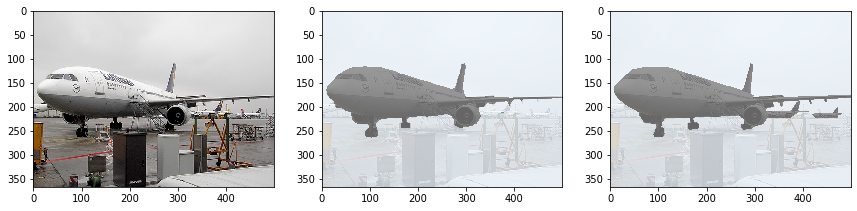

prediction num: [0 1]
prediction color: ['background', 'aeroplane']
prediction class: ['aliceblue', 'grey']
groundtruth num: [0 1]
groundtruth color: ['background', 'aeroplane']
groundtruth class: ['aliceblue', 'grey']


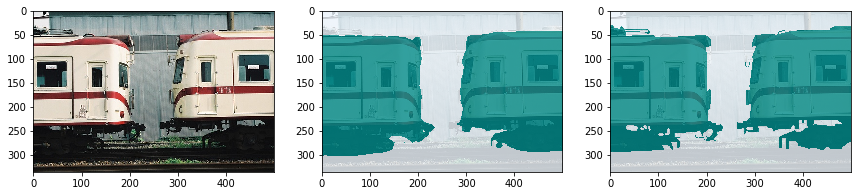

prediction num: [ 0 19]
prediction color: ['background', 'train']
prediction class: ['aliceblue', 'crimson']
groundtruth num: [ 0 19]
groundtruth color: ['background', 'train']
groundtruth class: ['aliceblue', 'crimson']


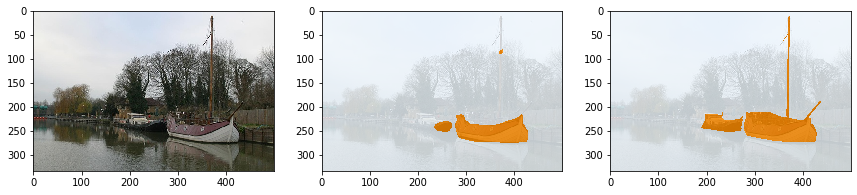

prediction num: [0 4]
prediction color: ['background', 'boat']
prediction class: ['aliceblue', 'darkorange']
groundtruth num: [0 4]
groundtruth color: ['background', 'boat']
groundtruth class: ['aliceblue', 'darkorange']


In [11]:
# test 2
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],           # [0.5,0.75,1.0,1.25,1.75]
    'flip': True,

    'ignore_label': 255,
    'num_classes':21,

    'model': 'deeplab_v3_s8',
    'freeze_bn': True,
    
    'if_png':True,
    'num_png':3

})

# import moxing as mox
data_path = './VOC2012'
# if not os.path.exists(data_path):
#     mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# dataset
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
cfg.data_lst = os.path.join(cfg.data_file,'ImageSets/Segmentation/val.txt')
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEGImages')
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './model'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)     #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-3_91.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)

net_eval(cfg)